In [2]:
import numpy as np
import geopandas as gpd
import pandas as pd
import rasterio as rio
import contextily
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import helpers

In [4]:
sns.set_style('darkgrid')

In [9]:
lz = gpd.read_file('../../../Data/IPC data/LZ_adm2_geometryFix.gpkg')
lz_wa = lz.query("ADMIN0 == 'Mali' or ADMIN0 == 'Chad' or ADMIN0 == 'Niger' or ADMIN0 == 'Nigeria'")

flood_dir = '../../../Data/DFO flood extents/'
ipc_dir = '../../../Data/IPC data/updated_files/'

flood_files = [i for i in os.listdir(flood_dir) if re.match(r'msw_20\d\d\.tif$', i)]
ipc_files = [i for i in os.listdir(ipc_dir) if re.match(r'^.*201[4-9].*\.tif$', i)]

flood_years = np.arange(2014, 2020)
flood_months = np.arange(6,10)
ipc_years = [fname.split('_')[1] for fname in ipc_files]
ipc_year_month = [(int(ym[:4]), int(ym[4:])) for ym in ipc_years]

Create Flood extent-IPC dataframe for all four countries of interest, combined:

In [12]:
df_wa = helpers.add_time_to_df(lz_wa, 'FIDcalc', flood_years, np.arange(1,13))

for i in range(len(ipc_files)):
    helpers.flood_ipc_rastercalc(df_wa, 
                         ipc_dir + ipc_files[i], 
                         ipc_year_month[i][0], 
                         [ipc_year_month[i][1]], 
                         ipc = 1)

for i in range(len(flood_files)):
    helpers.flood_ipc_rastercalc(df_wa,
                        flood_dir + flood_files[i],
                        flood_years[i],
                        flood_months,
                        ipc = 0)

df_wa.IPC_mean.fillna(method = 'backfill', inplace = True)
df_wa = df_wa.astype({'flood_prop': 'float', 'IPC_mean': 'float'})

Filter dataframe to only ADMIN2 regions where any flooding was detected for a given year:

In [95]:
df_wa_floodpresent = df_wa.groupby(['ADMIN2', 'Year']).filter(lambda x: (x['flood_prop'] > 0.20).any())

Groupby and filter to regions without flood or IPC data missing for any year:

In [141]:
gr_df = df_wa_floodpresent.groupby(['ADMIN2', 'datetime'], as_index = False).agg({'flood_prop': 'mean', 'IPC_mean': 'mean'})
gr_df = gr_df.groupby(['ADMIN2']).filter(lambda g: (g['flood_prop'].isnull().sum() == 48) | (g['IPC_mean'].isnull().values.any()))

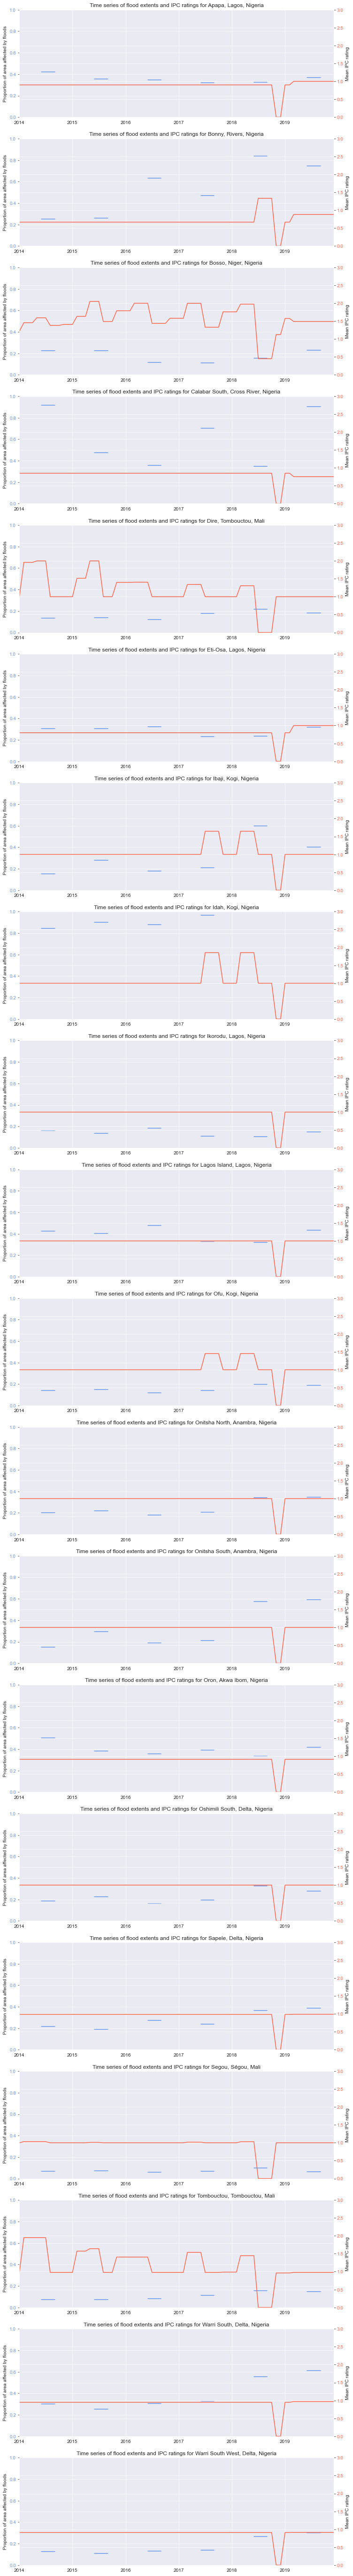

In [149]:
nrows = 20
fig, axes = plt.subplots(nrows, 1, figsize = (12, 100))

admin2_select = gr_df.ADMIN2.unique()

for i in range(nrows):
    adm2 = admin2_select[i]
    adm1 = df_wa_floodpresent.loc[df_wa_floodpresent.ADMIN2 == adm2]['ADMIN1'].unique()[0]
    adm0 = df_wa_floodpresent.loc[df_wa_floodpresent.ADMIN2 == adm2]['ADMIN0'].unique()[0]
    
    x = gr_df.loc[gr_df.ADMIN2 == '{}'.format(adm2)]['datetime']
    y1 = gr_df.loc[gr_df.ADMIN2 == '{}'.format(adm2)]['flood_prop']
    y2 = gr_df.loc[gr_df.ADMIN2 == '{}'.format(adm2)]['IPC_mean']
    
    ax1 = axes[i]
    ax1.set_ylabel('Proportion of area affected by floods')
    ax1.set_xlim(gr_df.datetime.min(), gr_df.datetime.max())
    ax1.set_ylim(0, 1.0)
    ax1.plot(x, y1, color = 'cornflowerblue')
    ax1.tick_params(axis = 'y', labelcolor = 'cornflowerblue')
    
    ax2 = ax1.twinx()
    ax2.set_ylabel('Mean IPC rating')
    ax2.set_ylim(0, 3)
    ax2.plot(x, y2, color = 'tomato')
    ax2.tick_params(axis = 'y', labelcolor = 'tomato')
    
    plt.title('Time series of flood extents and IPC ratings for {}, {}, {}'.format(adm2, adm1, adm0))


plt.show()

Looking at derivative of IPC values over time:

In [150]:
gr_df['IPC_slope'] = np.gradient(gr_df['IPC_mean'])

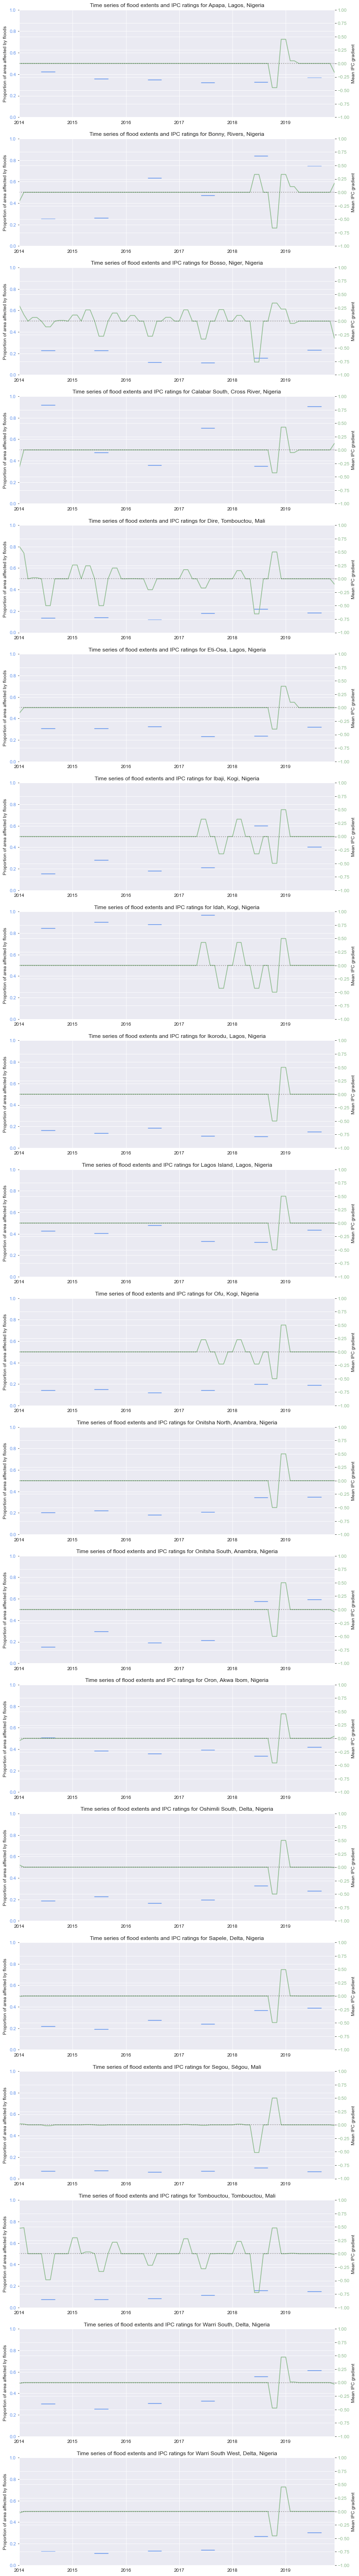

In [158]:
nrows = 20
fig, axes = plt.subplots(nrows, 1, figsize = (12, 100))

admin2_select = gr_df.ADMIN2.unique()

for i in range(nrows):
    adm2 = admin2_select[i]
    adm1 = df_wa_floodpresent.loc[df_wa_floodpresent.ADMIN2 == adm2]['ADMIN1'].unique()[0]
    adm0 = df_wa_floodpresent.loc[df_wa_floodpresent.ADMIN2 == adm2]['ADMIN0'].unique()[0]
    
    x = gr_df.loc[gr_df.ADMIN2 == '{}'.format(adm2)]['datetime']
    y1 = gr_df.loc[gr_df.ADMIN2 == '{}'.format(adm2)]['flood_prop']
    y2 = gr_df.loc[gr_df.ADMIN2 == '{}'.format(adm2)]['IPC_slope']
    
    ax1 = axes[i]
    ax1.set_ylabel('Proportion of area affected by floods')
    ax1.set_xlim(gr_df.datetime.min(), gr_df.datetime.max())
    ax1.set_ylim(0, 1.0)
    ax1.plot(x, y1, color = 'cornflowerblue')
    ax1.tick_params(axis = 'y', labelcolor = 'cornflowerblue')
    
    ax2 = ax1.twinx()
    ax2.set_ylabel('Mean IPC gradient')
    ax2.set_ylim(-1, 1)
    ax2.plot(x, y2, color = 'darkseagreen')
    ax2.plot(x, np.zeros(72), color = 'black', linestyle = ':', alpha = 0.5)
    ax2.tick_params(axis = 'y', labelcolor = 'darkseagreen')
    
    plt.title('Time series of flood extents and IPC gradient for {}, {}, {}'.format(adm2, adm1, adm0))


plt.show()

In [ ]:
with rio.open(flood_file[0]) as file:
    